In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install kaggle
!pip install fasttext

In [ ]:
!mkdir -p ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download nadyinky/sephora-products-and-skincare-reviews
!unzip '/content/sephora-products-and-skincare-reviews.zip'

In [ ]:
import os, shutil
import pandas as pd

In [ ]:
product_info = pd.read_csv('product_info.csv', sep=',')
print('original shape = ', product_info.shape)
keep_cols = [
  'product_id', 'product_name', 'ingredients', 'highlights',
  'primary_category', 'secondary_category', 'tertiary_category'
]
product_info = product_info[keep_cols]
required_cols = ['product_id', 'product_name', 'ingredients', 'highlights']
product_info = product_info.dropna(subset=required_cols)
product_info.drop_duplicates(subset='product_id', inplace=True)
print('cleaned shape = ', product_info.shape)

original shape =  (8494, 27)
cleaned shape =  (5820, 7)


In [ ]:
def clean_review_file(path, name):
  df = pd.read_csv(path, usecols=lambda col: col in columns_to_keep)
  print(f"{name}: original shape = {df.shape}")
  df = df.dropna()
  df['is_recommended'] = df['is_recommended'].astype(int)
  return df

columns_to_keep = ['is_recommended', 'review_text', 'product_id']
review_paths = {
  '0-250': 'reviews_0-250.csv',
  '250-500': 'reviews_250-500.csv',
  '500-750': 'reviews_500-750.csv',
  '750-1250': 'reviews_750-1250.csv',
  '1250-end': 'reviews_1250-end.csv'
}

cleaned_reviews = {}
for name, path in review_paths.items():
  df = clean_review_file(path, name)
  cleaned_reviews[name] = df
  print(f"{name}: cleaned shape = {df.shape}")

all_reviews_df = pd.concat(cleaned_reviews.values(), ignore_index=True)
positive_reviews = all_reviews_df[all_reviews_df['is_recommended'] == 1].copy()
negative_reviews = all_reviews_df[all_reviews_df['is_recommended'] == 0].copy()
print('positive reviews shape = ', positive_reviews.shape)
print('negative reviews shape = ', negative_reviews.shape)

0-250: original shape = (602130, 3)
0-250: cleaned shape = (483645, 3)
250-500: original shape = (206725, 3)
250-500: cleaned shape = (180567, 3)
500-750: original shape = (116262, 3)
500-750: cleaned shape = (104334, 3)
750-1250: original shape = (119317, 3)
750-1250: cleaned shape = (110332, 3)
1250-end: original shape = (49977, 3)
1250-end: cleaned shape = (46101, 3)
positive reviews shape =  (776965, 3)
negative reviews shape =  (148014, 3)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import shuffle
from transformers import BertTokenizer, BertModel
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sentence_transformers import SentenceTransformer
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Input, SimpleRNN, Dropout
from keras.optimizers import RMSprop
from keras import layers, regularizers
from nltk.stem import PorterStemmer
from collections import Counter
import torch
import numpy as np
import re
import matplotlib.pyplot as plt
import fasttext
import ast

In [ ]:
def extract_top_terms_by_cluster(
    texts, top_n=300, n_clusters=10, max_features=1000, min_df=5,
    max_df=0.7, stop_words='english', ngram_range=(1, 2), model_name='all-MiniLM-L6-v2'):

  # 1. TF-IDF 向量化
  vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    ngram_range=ngram_range
  )
  X = vectorizer.fit_transform(texts)
  feature_names = vectorizer.get_feature_names_out()

  # 2. 取出前 top_n 高分詞
  tfidf_scores = X.sum(axis=0).A1
  sorted_items = sorted(zip(tfidf_scores, feature_names), reverse=True)
  top_terms = [word for _, word in sorted_items[:top_n]]

  # 3. BERT 向量
  model = SentenceTransformer(model_name)
  embeddings = model.encode(top_terms)

  # 4. KMeans 聚類
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  labels = kmeans.fit_predict(embeddings)

  # 5. 整理群組關鍵詞
  clusters = {}
  for idx, label in enumerate(labels):
    clusters.setdefault(label, []).append(top_terms[idx])

  return clusters

In [ ]:
positive_clusters = extract_top_terms_by_cluster(positive_reviews['review_text'])
negative_clusters = extract_top_terms_by_cluster(negative_reviews['review_text'])

In [ ]:
for cid, words in positive_clusters.items():
  print(f"[Positive Cluster {cid}], keywords: {words}")

for cid, words in negative_clusters.items():
  print(f"[Negative Cluster {cid}], keywords: {words}")

[Positive Cluster 2], keywords: ['skin', 'face', 'moisturizer', 'cream', 'makeup', 'serum', 'acne', 'dry skin', 'sensitive skin', 'lips', 'sunscreen', 'skincare', 'moisturizing', 'skin feels', 'makes skin', 'leaves skin', 'skin feel', 'skin feeling', 'lip', 'toner', 'eye cream', 'oily skin', 'breakouts', 'skin looks', 'retinol', 'combination skin', 'acne prone', 'skin soft', 'facial', 'sephora', 'skin care', 'skin felt', 'skincare routine', 'difference skin', 'wrinkles']
[Positive Cluster 8], keywords: ['product', 'use', 'using', 'used', 'received', 'products', 'free', 'results', 'price', 'sample', 'need', 'received product', 'worth', 'buy', 've using', 'sure', 'using product', 've used', 'purchase', 'bought', 'brand', 'formula', 'want', 'application', 'product free', 'area', 'product complimentary', 'getting', 'refreshed', 'purposes', 'expensive', 'buying', 'combo', 'applied', 'extra']
[Positive Cluster 4], keywords: ['love', 'great', 'amazing', 'good', 'recommend', 'nice', 'super', '

In [ ]:
cluster_id_to_name_pos = {
  0: "Texture & Radiant Skin",
  1: "Moisturizing & Gentle",
  2: "Strong Recommendation"
}

keyword_to_tag_pos = {
  # Cluster 0 – Texture & Radiant Skin
  "soft": 0,
  "glow": 0,
  "brighter": 0,
  "radiant": 0,
  "tone": 0,
  "even skin": 0,
  "smooth": 0,
  "plump": 0,
  "dewy": 0,

  # Cluster 1 – Moisturizing & Gentle
  "moisturize": 1,
  "hydrate": 1,
  "gentle": 1,
  "soothing": 1,
  "sensitive skin": 1,
  "acne prone": 1,
  "combination skin": 1,
  "non irritating": 1,
  "absorbs": 1,
  "non greasy": 1,
  "lightweight": 1,
  'dry': 1,

  # Cluster 2 – Strong Recommendation
  "love": 2,
  "recommend": 2,
  "favorite": 2,
  "best": 2,
  "wonderful": 2
}

cluster_id_to_name_neg = {
  0: "No Visible Change",
  1: "Scent",
  2: "Ineffectiveness",
  3: "Specific Area or Routine Issues",
  4: "Texture and Hydration Problems",
  5: "Skin Type Sensitivity"
}

keyword_to_tag_neg = {
  # Cluster 0 – No Visible Change
  "no difference": 0,
  "time": 0,
  "little": 0,
  "long": 0,

  # Cluster 1 – Scent
  "smell": 1,
  "scent": 1,
  "fragrance": 1,
  "strong": 1,
  "packaging": 1,
  "waste": 1,
  "money": 1,
  "heavy": 1,
  "light": 1,
  "brand": 1,
  "complimentary": 1,

  # Cluster 2 – Ineffectiveness
  "didn work": 2,
  "didn’t help": 2,
  "tried": 2,
  "stopped": 2,

  # Cluster 3 – Specific Area or Routine Issues
  "eye": 3,
  "face": 3,
  "makeup": 3,
  "mask": 3,
  "routine": 3,
  "spots": 3,
  "cheeks": 3,
  "forehead": 3,
  "breakout": 3,
  "lips": 3,

  # Cluster 4 – Texture and Hydration Problems
  "dry": 4,
  "sticky": 4,
  "greasy": 4,
  "moisturizer": 4,
  "texture": 4,
  "hydrating": 4,
  "hydration": 4,
  "oil": 4,
  "cream": 4,
  "dried": 4,
  "balm": 4,
  "watery": 4,
  "serum": 4,

  # Cluster 5 – Skin Type Sensitivity
  "acne": 5,
  "pimples": 5,
  "bumps": 5,
  "sensitive skin": 5,
  "dry skin": 5,
  "oily skin": 5,
  "acne prone": 5
}

In [ ]:
stemmer = PorterStemmer()
# 建立詞幹對照字典
def build_stemmed_keyword_map(keyword_to_tag):
  stemmed_map = {}
  for phrase, tag in keyword_to_tag.items():
    words = phrase.lower().split()
    stemmed_phrase = " ".join(stemmer.stem(word) for word in words)
    stemmed_map[stemmed_phrase] = tag
  return stemmed_map

# 標記函數（詞幹比對版本）
def classify_review_tags_with_stemming(text, stemmed_keyword_to_tag):
  if not isinstance(text, str) or text.strip() == "":
    return []
  text = text.lower()
  words = re.findall(r'\b\w+\b', text)
  stemmed_words = [stemmer.stem(w) for w in words]
  joined_text = " ".join(stemmed_words)

  tags = set()
  for stemmed_phrase, tag in stemmed_keyword_to_tag.items():
    if stemmed_phrase in joined_text:
      tags.add(tag)
  return list(tags)

# 合併所有標籤並計算頻率
def top_k_labels(tag_lists, k, min_freq):
  all_labels = [label for tags in tag_lists for label in tags]
  counts = Counter(all_labels)
  total = len(all_labels)
  freq = {label: count / total for label, count in counts.items()}
  selected = [label for label, f in sorted(freq.items(), key=lambda x: x[1], reverse=True) if f >= min_freq][:k]
  return selected

In [ ]:
stemmed_keyword_to_tag_pos = build_stemmed_keyword_map(keyword_to_tag_pos)
positive_reviews["pos_tags"] = positive_reviews["review_text"].apply(
  lambda text: classify_review_tags_with_stemming(text, stemmed_keyword_to_tag_pos)
)
positive_reviews['pos_tags'] = positive_reviews['pos_tags'].apply(
  lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
df_pos_groupby = positive_reviews.groupby('product_id')['pos_tags'].apply(
  lambda lists: top_k_labels(lists, k=2, min_freq=0.2)
).reset_index()
df_pos_groupby = df_pos_groupby[df_pos_groupby['pos_tags'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
df_pos = df_pos_groupby.merge(product_info, on='product_id', how='inner')
df_pos.to_csv('/content/drive/MyDrive/Colab Notebooks/dataset_final/df_pos.csv', index=False)

lengths = df_pos['pos_tags'].apply(len)
print('平均主題數:', lengths.mean())
print('正面回饋資料數: ', df_pos.shape)
df_pos.head()

平均主題數: 1.9698438341410878
正面回饋資料數:  (1857, 8)


,product_id,pos_tags,product_name,ingredients,highlights,primary_category,secondary_category,tertiary_category
0,P114902,"[2, 1]",Goodbye Acne Max Complexion Correction Pads,"['Salicylic Acid 2%, Alcohol Denat., Water/Aqu...","['Good for: Pores', 'Good for: Acne/Blemishes'...",Skincare,Treatments,Blemish & Acne Treatments
1,P12045,"[1, 2]",Grape Water Moisturizing Face Mist,"['Vitis Vinifera (Grape) Fruit Water*, Vitis V...","['Good for: Redness', 'Best for Dry Skin', 'Cl...",Skincare,Moisturizers,Mists & Essences
2,P122718,"[2, 1]",Exfoliating Face Scrub,"['Water\\Aqua\\Eau, Glyceryl Stearate, Silica,...","['Best for Oily Skin', 'Good for: Dullness/Une...",Skincare,Cleansers,Exfoliators
3,P122762,"[2, 1]",Rinse-Off Foaming Cleanser,"['Water/Aqua/Eau, Potassium Myristate, Glyceri...","['Hyaluronic Acid', 'Gluten Free', 'Oil Free',...",Skincare,Cleansers,Face Wash & Cleansers
4,P122774,"[1, 2]",All About Eyes Eye Cream,"['Cyclopentasiloxane, Water, Isostearyl Palmit...","['Good for: Dark Circles', 'Without Sulfates S...",Skincare,Eye Care,Eye Creams & Treatments


In [ ]:
stemmed_keyword_to_tag_neg = build_stemmed_keyword_map(keyword_to_tag_neg)
negative_reviews["neg_tags"] = negative_reviews["review_text"].apply(
  lambda text: classify_review_tags_with_stemming(text, stemmed_keyword_to_tag_neg)
)
negative_reviews['neg_tags'] = negative_reviews['neg_tags'].apply(
  lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
df_neg_groupby = negative_reviews.groupby('product_id')['neg_tags'].apply(
  lambda lists: top_k_labels(lists, k=3, min_freq=0.1)
).reset_index()
df_neg_groupby = df_neg_groupby[df_neg_groupby['neg_tags'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
df_neg = df_neg_groupby.merge(product_info, on='product_id', how='inner')
df_neg.to_csv('/content/drive/MyDrive/Colab Notebooks/dataset_final/df_neg.csv', index=False)

lengths = df_neg['neg_tags'].apply(len)
print('平均主題數:', lengths.mean())
print('負面回饋資料數: ', df_neg.shape)
df_neg.head()

平均主題數: 2.9146757679180886
負面回饋資料數:  (1758, 8)


,product_id,neg_tags,product_name,ingredients,highlights,primary_category,secondary_category,tertiary_category
0,P114902,"[1, 3, 4]",Goodbye Acne Max Complexion Correction Pads,"['Salicylic Acid 2%, Alcohol Denat., Water/Aqu...","['Good for: Pores', 'Good for: Acne/Blemishes'...",Skincare,Treatments,Blemish & Acne Treatments
1,P12045,"[4, 1, 3]",Grape Water Moisturizing Face Mist,"['Vitis Vinifera (Grape) Fruit Water*, Vitis V...","['Good for: Redness', 'Best for Dry Skin', 'Cl...",Skincare,Moisturizers,Mists & Essences
2,P122718,"[1, 4, 3]",Exfoliating Face Scrub,"['Water\\Aqua\\Eau, Glyceryl Stearate, Silica,...","['Best for Oily Skin', 'Good for: Dullness/Une...",Skincare,Cleansers,Exfoliators
3,P122762,"[3, 4]",Rinse-Off Foaming Cleanser,"['Water/Aqua/Eau, Potassium Myristate, Glyceri...","['Hyaluronic Acid', 'Gluten Free', 'Oil Free',...",Skincare,Cleansers,Face Wash & Cleansers
4,P122774,"[3, 4, 0]",All About Eyes Eye Cream,"['Cyclopentasiloxane, Water, Isostearyl Palmit...","['Good for: Dark Circles', 'Without Sulfates S...",Skincare,Eye Care,Eye Creams & Treatments


In [ ]:
df_pos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_final/df_pos.csv')
df_neg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_final/df_neg.csv')

In [ ]:
!wget -P /content/ 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz'
!gunzip /content/cc.en.300.bin.gz
ft = fasttext.load_model('/content/cc.en.300.bin')

Positive dataset

In [ ]:
texts = df_pos.apply(
  lambda row: ' '.join([
    str(row['ingredients']),
    str(row['highlights']),
    str(row['primary_category']),
    str(row['secondary_category']),
    str(row['tertiary_category'])
  ]), axis=1).values

lengths = [len(text.split()) for text in texts]
print(f'平均長度: {sum(lengths)/len(lengths):.2f}')
print(f'最大長度: {max(lengths)}')
print(f'中位數長度: {sorted(lengths)[len(lengths)//2]}')

平均長度: 110.90
最大長度: 1106
中位數長度: 97


In [ ]:
max_features = 5000
maxlen = 256

# 1. 切割訓練集與測試集
labels = df_pos['pos_tags'].values
texts, labels = shuffle(texts, labels, random_state=100)
train_size = 1480
test_size = 370
texts_train = texts[:train_size]
labels_train = labels[:train_size]
texts_test = texts[train_size:train_size+test_size]
labels_test = labels[train_size:train_size+test_size]

# 1.1. 建 tokenizer 並擷取 word_index
tokenizer = Tokenizer(num_words=max_features, oov_token="<UNK>")
tokenizer.fit_on_texts(texts_train)
word_index = tokenizer.word_index

# 1.2. Tokenize & pad
seq_train = tokenizer.texts_to_sequences(texts_train)
x_train = pad_sequences(seq_train, maxlen=maxlen, padding='post', truncating='post')
seq_test = tokenizer.texts_to_sequences(texts_test)
x_test = pad_sequences(seq_test, maxlen=maxlen, padding='post', truncating='post')

# 1.3. 多標籤處理
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(labels_train)
y_test = mlb.transform(labels_test)

# 2. 讀取 Fasttext 預訓練詞向量
# 2.1. 建 embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
  if i < max_features:
    embedding_matrix[i] = ft.get_word_vector(word)

# 2.2. 做 embedding 層
embedding_layer = Embedding(
  input_dim=max_features,
  output_dim=embedding_dim,
  weights=[embedding_matrix],
  input_length=maxlen,
  trainable=True
)

In [ ]:
covered = np.sum(np.any(embedding_matrix != 0, axis=1))
print(f'被 Fasttext 覆蓋的詞數: {covered} / {max_features} = ', covered/max_features)

被 Fasttext 覆蓋的詞數: 4646 / 5000 =  0.9292


Negative dataset

In [ ]:
texts = df_neg.apply(
  lambda row: ' '.join([
  str(row['ingredients']),
  str(row['highlights']),
  str(row['primary_category']),
  str(row['secondary_category']),
  str(row['tertiary_category'])
  ]), axis=1).values

lengths = [len(text.split()) for text in texts]
print(f'平均長度: {sum(lengths)/len(lengths):.2f}')
print(f'最大長度: {max(lengths)}')
print(f'中位數長度: {sorted(lengths)[len(lengths)//2]}')

平均長度: 108.89
最大長度: 752
中位數長度: 96


In [ ]:
max_features = 5000
maxlen = 256

# 1. 切割訓練集與測試集
labels = df_neg['neg_tags'].values
texts, labels = shuffle(texts, labels, random_state=100)
train_size = 1400
test_size = 350
texts_train = texts[:train_size]
labels_train = labels[:train_size]
texts_test = texts[train_size:train_size+test_size]
labels_test = labels[train_size:train_size+test_size]

# 1.1. 建 tokenizer 並擷取 word_index
tokenizer = Tokenizer(num_words=max_features, oov_token="<UNK>")
tokenizer.fit_on_texts(texts_train)
word_index = tokenizer.word_index

# 1.2. Tokenize & pad
seq_train = tokenizer.texts_to_sequences(texts_train)
x_train = pad_sequences(seq_train, maxlen=maxlen, padding='post', truncating='post')
seq_test = tokenizer.texts_to_sequences(texts_test)
x_test = pad_sequences(seq_test, maxlen=maxlen, padding='post', truncating='post')

# 1.3. 多標籤處理
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(labels_train)
y_test = mlb.transform(labels_test)

# 2. 使用 FastText 預訓練詞向量
# 2.1. 建 embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
  if i < max_features:
    embedding_matrix[i] = ft.get_word_vector(word)

# 2.2. 做 embedding 層
embedding_layer = Embedding(
  input_dim=max_features,
  output_dim=embedding_dim,
  weights=[embedding_matrix],
  input_length=maxlen,
  trainable=True
)

In [ ]:
covered = np.sum(np.any(embedding_matrix != 0, axis=1))
print(f'被 Fasttext 覆蓋的詞數: {covered} / {max_features} = ', covered/max_features)

被 Fasttext 覆蓋的詞數: 4471 / 5000 =  0.8942


Model Structure

In [ ]:
def build_model(cell_type, use_regularization=False, use_dropout=False):
  model = Sequential()
  model.add(embedding_layer)

  if cell_type == 'rnn':
    model.add(SimpleRNN(32))
  elif cell_type == 'lstm':
    model.add(layers.Bidirectional(layers.LSTM(32)))
  elif cell_type == 'gru':
    model.add(layers.Bidirectional(layers.GRU(32)))

  if use_regularization:
    model.add(Dense(y_train.shape[1], activation='sigmoid',
      kernel_regularizer=regularizers.l1(0.001)))
  if use_dropout:
    model.add(Dropout(0.5))

  model.add(Dense(y_train.shape[1], activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall(), BinaryAccuracy()])
  return model

# Model-Positive

A. RNN

In [ ]:
model = build_model(cell_type='rnn')
history_A = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
best_epoch_A = history_A.history['val_loss'].index(min(history_A.history['val_loss']))
print('最佳訓練次數：', best_epoch_A+1)

最佳訓練次數： 15


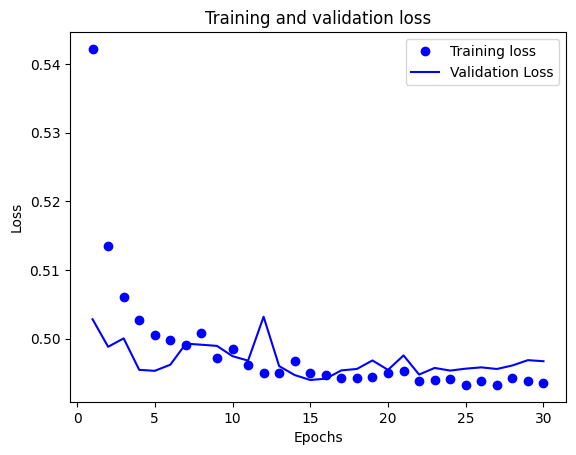

In [ ]:
loss = history_A.history['loss']
val_loss_values = history_A.history['val_loss']
epochs = range(1, len(val_loss_values)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = build_model(cell_type='rnn')
model.fit(x_train, y_train, epochs=best_epoch_A+1, batch_size=32, verbose=0)
results_A = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob>0.5).astype(int)
micro_A = f1_score(y_test, y_pred, average='micro')
macro_A = f1_score(y_test, y_pred, average='macro')
print('Micro', f1_score(y_test, y_pred, average='micro'))
print('Macro', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=[str(x) for x in mlb.classes_]))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - binary_accuracy: 0.7841 - loss: 0.5041 - precision_25: 0.8300 - recall_25: 0.8432
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Micro 0.8385772913816689
Macro 0.6304970382668224
              precision    recall  f1-score   support

           0       0.62      0.05      0.09       109
           1       0.78      0.98      0.87       288
           2       0.88      0.99      0.94       327

   micro avg       0.83      0.85      0.84       724
   macro avg       0.76      0.67      0.63       724
weighted avg       0.80      0.85      0.78       724
 samples avg       0.83      0.85      0.84       724



B. Bidirection LSTM

In [ ]:
model = build_model(cell_type='lstm')
history_B = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
best_epoch_B = history_B.history['val_loss'].index(min(history_B.history['val_loss']))
print('最佳訓練次數：', best_epoch_B+1)

最佳訓練次數： 3


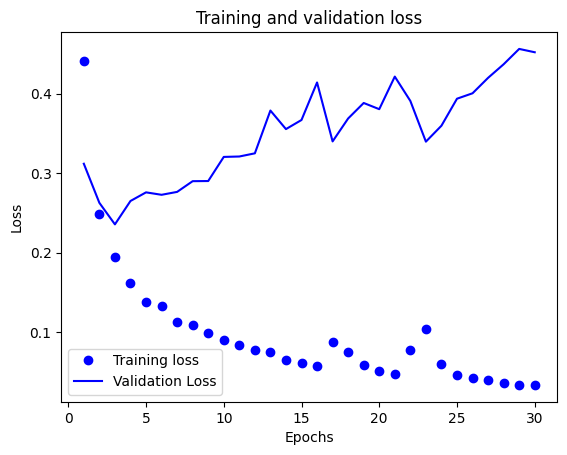

In [ ]:
loss = history_B.history['loss']
val_loss_values = history_B.history['val_loss']
epochs = range(1, len(val_loss_values)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = build_model(cell_type='lstm')
model.fit(x_train, y_train, epochs=best_epoch_B+1, batch_size=32, verbose=0)
results_B = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob>0.5).astype(int)
micro_B = f1_score(y_test, y_pred, average='micro')
macro_B = f1_score(y_test, y_pred, average='macro')
print('Micro', f1_score(y_test, y_pred, average='micro'))
print('Macro', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=[str(x) for x in mlb.classes_]))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7949 - loss: 0.5748 - precision_23: 0.8327 - recall_23: 0.8596
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Micro 0.8445349626612356
Macro 0.7783350425535837
              precision    recall  f1-score   support

           0       0.54      0.55      0.54       109
           1       0.86      0.88      0.87       288
           2       0.90      0.94      0.92       327

   micro avg       0.83      0.86      0.84       724
   macro avg       0.77      0.79      0.78       724
weighted avg       0.83      0.86      0.84       724
 samples avg       0.83      0.86      0.84       724



C. Bidirection GRU

In [ ]:
model = build_model(cell_type='gru')
history_C = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
best_epoch_C = history_C.history['val_loss'].index(min(history_C.history['val_loss']))
print('最佳訓練次數：', best_epoch_C+1)

最佳訓練次數： 2


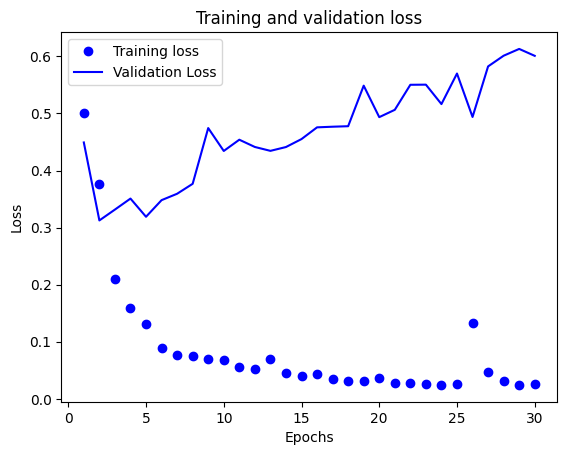

In [ ]:
loss = history_C.history['loss']
val_loss_values = history_C.history['val_loss']
epochs = range(1, len(val_loss_values)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = build_model(cell_type='gru')
model.fit(x_train, y_train, epochs=best_epoch_C+1, batch_size=32, verbose=0)
results_C = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob>0.5).astype(int)
micro_C = f1_score(y_test, y_pred, average='micro')
macro_C = f1_score(y_test, y_pred, average='macro')
print('Micro', f1_score(y_test, y_pred, average='micro'))
print('Macro', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=[str(x) for x in mlb.classes_]))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.7923 - loss: 0.5131 - precision_27: 0.8224 - recall_27: 0.8711
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Micro 0.8475935828877005
Macro 0.7852018508267924
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       109
           1       0.86      0.84      0.85       288
           2       0.88      1.00      0.94       327

   micro avg       0.82      0.88      0.85       724
   macro avg       0.76      0.81      0.79       724
weighted avg       0.82      0.88      0.85       724
 samples avg       0.83      0.88      0.85       724



A, B, C 模型比較

In [ ]:
model_names = ['A', 'B', 'C']
testing_loss_values = [results_A[0], results_B[0], results_C[0]]
testing_micro = [micro_A, micro_B, micro_C]
testing_macro = [macro_A, macro_B, macro_C]

df = pd.DataFrame({'Model': model_names,
          'Testing Loss': testing_loss_values,
          'Testing micro': testing_micro,
          'Testing macro': testing_macro})
print(df)

  Model  Testing Loss  Testing micro  Testing macro
0     A      0.502236       0.838577       0.630497
1     B      0.588754       0.844535       0.778335
2     C      0.516547       0.847594       0.785202


D. GRU + L1

In [ ]:
model = build_model(cell_type='gru', use_regularization=True)
history_D = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
best_epoch_D = history_D.history['val_loss'].index(min(history_D.history['val_loss']))
print('最佳訓練次數：', best_epoch_D+1)

最佳訓練次數： 30


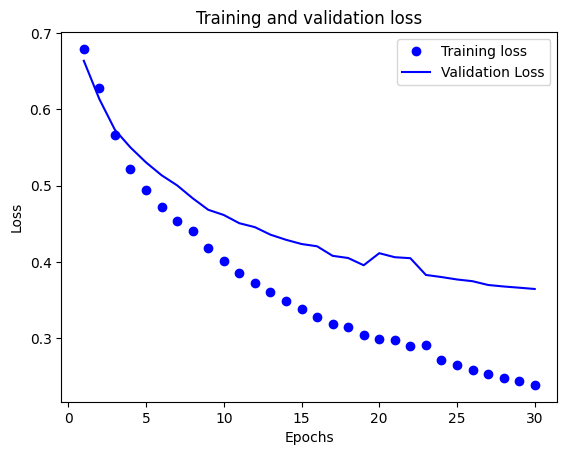

In [ ]:
loss = history_D.history['loss']
val_loss_values = history_D.history['val_loss']
epochs = range(1, len(val_loss_values)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = build_model(cell_type='gru', use_regularization=True)
model.fit(x_train, y_train, epochs=best_epoch_D+1, batch_size=32, verbose=0)
results_D = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob>0.5).astype(int)
micro_D = f1_score(y_test, y_pred, average='micro')
macro_D = f1_score(y_test, y_pred, average='macro')
print('Micro', f1_score(y_test, y_pred, average='micro'))
print('Macro', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=[str(x) for x in mlb.classes_]))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7846 - loss: 0.5372 - precision_35: 0.8111 - recall_35: 0.8753
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Micro 0.8425925925925926
Macro 0.7709076481026497
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       109
           1       0.83      0.87      0.85       288
           2       0.88      1.00      0.94       327

   micro avg       0.81      0.88      0.84       724
   macro avg       0.74      0.80      0.77       724
weighted avg       0.81      0.88      0.84       724
 samples avg       0.82      0.88      0.84       724



E. GRU + Dropout

In [ ]:
model = build_model(cell_type='gru', use_dropout=True)
history_E = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
best_epoch_E = history_E.history['val_loss'].index(min(history_E.history['val_loss']))
print('最佳訓練次數：', best_epoch_E+1)

最佳訓練次數： 4


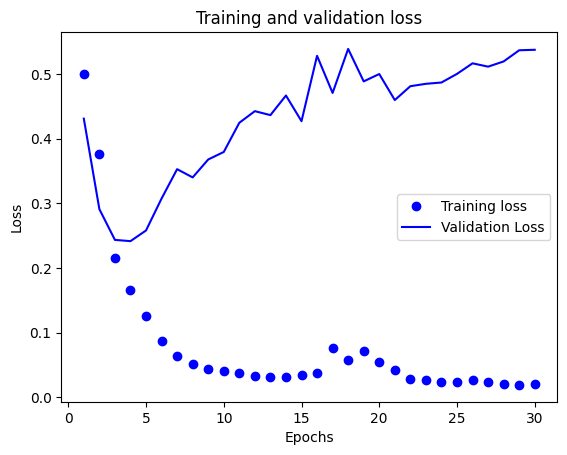

In [ ]:
loss = history_E.history['loss']
val_loss_values = history_E.history['val_loss']
epochs = range(1, len(val_loss_values)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = build_model(cell_type='gru', use_dropout=True)
model.fit(x_train, y_train, epochs=best_epoch_E+1, batch_size=32, verbose=0)
results_E = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob>0.5).astype(int)
micro_E = f1_score(y_test, y_pred, average='micro')
macro_E = f1_score(y_test, y_pred, average='macro')
print('Micro', f1_score(y_test, y_pred, average='micro'))
print('Macro', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=[str(x) for x in mlb.classes_]))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7620 - loss: 0.6972 - precision_33: 0.8132 - recall_33: 0.8265
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Micro 0.8177474402730376
Macro 0.7562026229233808
              precision    recall  f1-score   support

           0       0.49      0.57      0.53       109
           1       0.84      0.83      0.84       288
           2       0.90      0.91      0.91       327

   micro avg       0.81      0.83      0.82       724
   macro avg       0.74      0.77      0.76       724
weighted avg       0.82      0.83      0.82       724
 samples avg       0.81      0.83      0.82       724



C, D, E 模型比較

In [ ]:
model_names = ['C', 'D', 'E']
testing_loss_values = [results_C[0], results_D[0], results_E[0]]
testing_micro = [micro_C, micro_D, micro_E]
testing_macro = [macro_C, macro_D, macro_E]

df = pd.DataFrame({'Model': model_names,
          'Testing Loss': testing_loss_values,
          'Testing micro': testing_micro,
          'Testing macro': testing_macro})
print(df)

  Model  Testing Loss  Testing micro  Testing macro
0     C      0.516547       0.847594       0.785202
1     D      0.536545       0.842593       0.770908
2     E      0.709919       0.817747       0.756203


# Model-Negative

A. RNN

In [ ]:
model = build_model(cell_type='rnn')
history_A = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
best_epoch_A = history_A.history['val_loss'].index(min(history_A.history['val_loss']))
print('最佳訓練次數：', best_epoch_A+1)

最佳訓練次數： 30


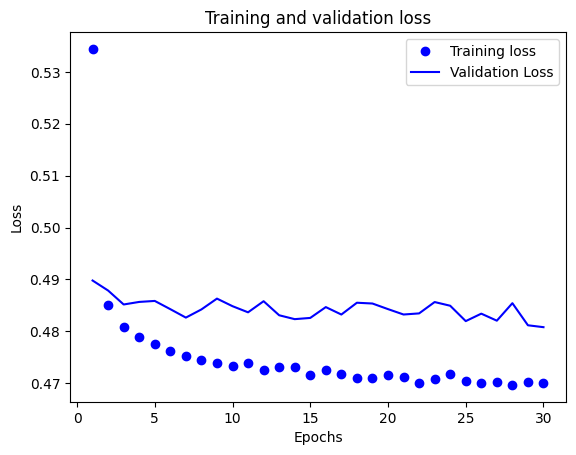

In [ ]:
loss = history_A.history['loss']
val_loss_values = history_A.history['val_loss']
epochs = range(1, len(val_loss_values)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = build_model(cell_type='rnn')
model.fit(x_train, y_train, epochs=best_epoch_A+1, batch_size=32, verbose=0)
results_A = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob>0.5).astype(int)
micro_A = f1_score(y_test, y_pred, average='micro')
macro_A = f1_score(y_test, y_pred, average='macro')
print('Micro', f1_score(y_test, y_pred, average='micro'))
print('Macro', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=[str(x) for x in mlb.classes_]))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - binary_accuracy: 0.8042 - loss: 0.4874 - precision_43: 0.7937 - recall_43: 0.8076
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Micro 0.790314769975787
Macro 0.45178959392884216
              precision    recall  f1-score   support

           0       0.33      0.01      0.03        72
           1       0.75      1.00      0.85       259
           2       0.20      0.01      0.03        69
           3       0.75      0.97      0.85       263
           4       0.86      0.99      0.92       303
           5       0.33      0.02      0.03        56

   micro avg       0.78      0.80      0.79      1022
   macro avg       0.54      0.50      0.45      1022
weighted avg       0.69      0.80      0.71      1022
 samples avg       0.78      0.80      0.79      1022



B. Bidirection LSTM

In [ ]:
model = build_model(cell_type='lstm')
history_B = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
best_epoch_B = history_B.history['val_loss'].index(min(history_B.history['val_loss']))
print('最佳訓練次數：', best_epoch_B+1)

最佳訓練次數： 4


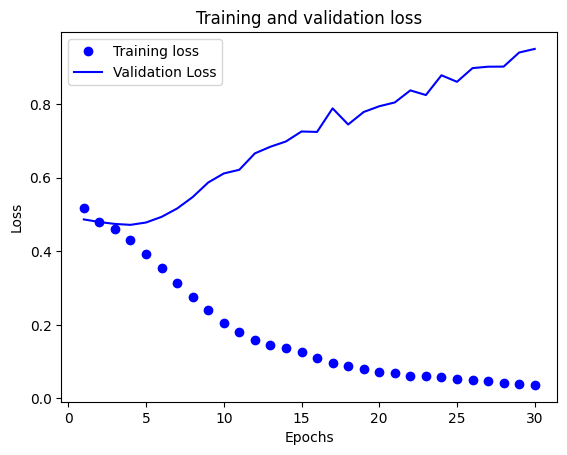

In [ ]:
loss = history_B.history['loss']
val_loss_values = history_B.history['val_loss']
epochs = range(1, len(val_loss_values)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = build_model(cell_type='lstm')
model.fit(x_train, y_train, epochs=best_epoch_B+1, batch_size=32, verbose=0)
results_B = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob>0.5).astype(int)
micro_B = f1_score(y_test, y_pred, average='micro')
macro_B = f1_score(y_test, y_pred, average='macro')
print('Micro', f1_score(y_test, y_pred, average='micro'))
print('Macro', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=[str(x) for x in mlb.classes_]))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.7888 - loss: 0.5593 - precision_39: 0.7874 - recall_39: 0.7755
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Micro 0.7775590551181102
Macro 0.49696363355888856
              precision    recall  f1-score   support

           0       0.50      0.07      0.12        72
           1       0.76      0.93      0.84       259
           2       0.37      0.10      0.16        69
           3       0.76      0.92      0.83       263
           4       0.88      0.96      0.92       303
           5       0.25      0.07      0.11        56

   micro avg       0.78      0.77      0.78      1022
   macro avg       0.59      0.51      0.50      1022
weighted avg       0.72      0.77      0.72      1022
 samples avg       0.79      0.77      0.77      1022



C. Bidirection GRU

In [ ]:
model = build_model(cell_type='gru')
history_C = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
best_epoch_C = history_C.history['val_loss'].index(min(history_C.history['val_loss']))
print('最佳訓練次數：', best_epoch_C+1)

最佳訓練次數： 3


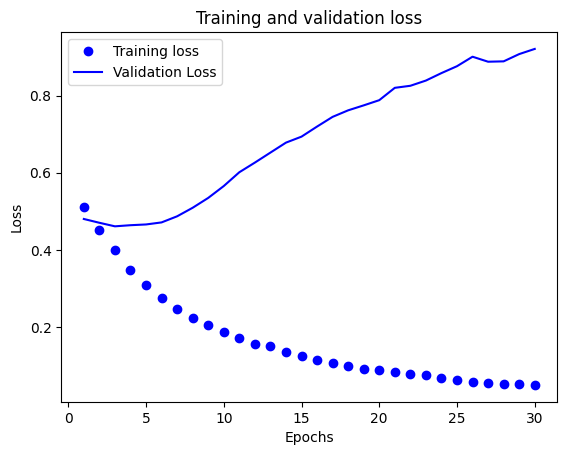

In [ ]:
loss = history_C.history['loss']
val_loss_values = history_C.history['val_loss']
epochs = range(1, len(val_loss_values)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = build_model(cell_type='gru')
model.fit(x_train, y_train, epochs=best_epoch_C+1, batch_size=32, verbose=0)
results_C = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob>0.5).astype(int)
micro_C = f1_score(y_test, y_pred, average='micro')
macro_C = f1_score(y_test, y_pred, average='macro')
print(classification_report(y_test, y_pred, target_names=[str(x) for x in mlb.classes_]))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - binary_accuracy: 0.7912 - loss: 0.4789 - precision_41: 0.7815 - recall_41: 0.7926
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
              precision    recall  f1-score   support

           0       0.17      0.03      0.05        72
           1       0.77      0.96      0.85       259
           2       0.29      0.12      0.16        69
           3       0.76      0.95      0.85       263
           4       0.88      0.98      0.93       303
           5       0.33      0.05      0.09        56

   micro avg       0.78      0.79      0.79      1022
   macro avg       0.53      0.52      0.49      1022
weighted avg       0.70      0.79      0.73      1022
 samples avg       0.78      0.79      0.78      1022



A, B, C 模型比較

In [ ]:
model_names = ['A', 'B', 'C']
testing_loss_values = [results_A[0], results_B[0], results_C[0]]
testing_micro = [micro_A, micro_B, micro_C]
testing_macro = [macro_A, macro_B, macro_C]

df = pd.DataFrame({'Model': model_names,
          'Testing Loss': testing_loss_values,
          'Testing micro': testing_micro,
          'Testing macro': testing_macro})
print(df)

  Model  Testing Loss  Testing micro  Testing macro
0     A      0.502036       0.790315       0.451790
1     B      0.578191       0.777559       0.496964
2     C      0.485699       0.786026       0.489157


D. RNN + L1

In [ ]:
model = build_model(cell_type='rnn', use_regularization=True)
history_D = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
best_epoch_D = history_D.history['val_loss'].index(min(history_D.history['val_loss']))
print('最佳訓練次數：', best_epoch_D+1)

最佳訓練次數： 30


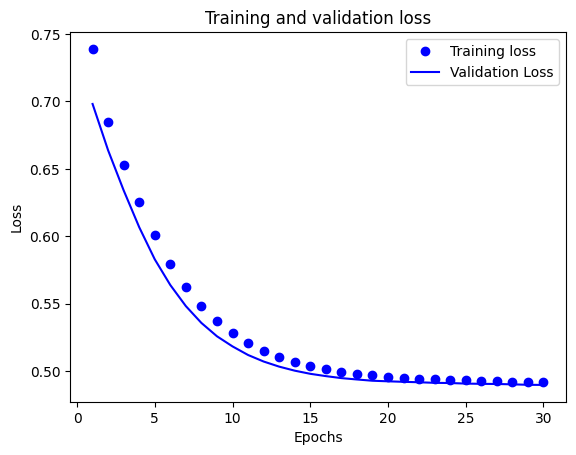

In [ ]:
loss = history_D.history['loss']
val_loss_values = history_D.history['val_loss']
epochs = range(1, len(val_loss_values)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = build_model(cell_type='rnn', use_regularization=True)
model.fit(x_train, y_train, epochs=best_epoch_D+1, batch_size=32, verbose=0)
results_D = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob>0.5).astype(int)
micro_D = f1_score(y_test, y_pred, average='micro')
macro_D = f1_score(y_test, y_pred, average='macro')
print('Micro', f1_score(y_test, y_pred, average='micro'))
print('Macro', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=[str(x) for x in mlb.classes_]))

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - binary_accuracy: 0.8082 - loss: 0.4889 - precision_45: 0.7949 - recall_45: 0.8167
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Micro 0.7963320463320464
Macro 0.4394457092873005
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.74      1.00      0.85       259
           2       0.00      0.00      0.00        69
           3       0.75      1.00      0.86       263
           4       0.87      1.00      0.93       303
           5       0.00      0.00      0.00        56

   micro avg       0.79      0.81      0.80      1022
   macro avg       0.39      0.50      0.44      1022
weighted avg       0.64      0.81      0.71      1022
 samples avg       0.79      0.81      0.79      1022



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


E. RNN + Dropout

In [ ]:
model = build_model(cell_type='rnn', use_dropout=True)
history_E = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
best_epoch_E = history_E.history['val_loss'].index(min(history_E.history['val_loss']))
print('最佳訓練次數：', best_epoch_E+1)

最佳訓練次數： 26


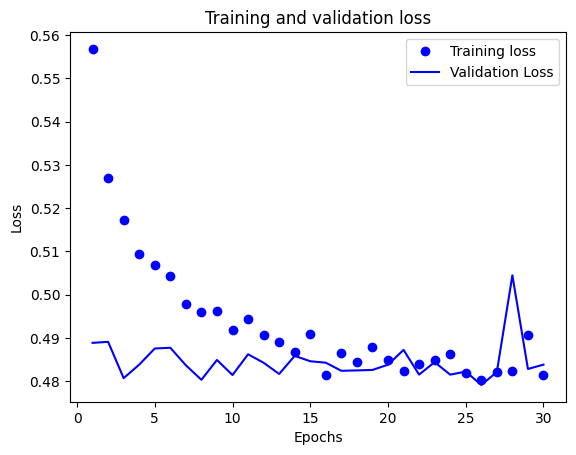

In [ ]:
loss = history_E.history['loss']
val_loss_values = history_E.history['val_loss']
epochs = range(1, len(val_loss_values)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = build_model(cell_type='rnn', use_dropout=True)
model.fit(x_train, y_train, epochs=best_epoch_E+1, batch_size=32, verbose=0)
results_E = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob>0.5).astype(int)
micro_E = f1_score(y_test, y_pred, average='micro')
macro_E = f1_score(y_test, y_pred, average='macro')
print('Micro', f1_score(y_test, y_pred, average='micro'))
print('Macro', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=[str(x) for x in mlb.classes_]))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - binary_accuracy: 0.8033 - loss: 0.4893 - precision_47: 0.7891 - recall_47: 0.8131
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Micro 0.7903381642512077
Macro 0.450017278438475
              precision    recall  f1-score   support

           0       0.43      0.04      0.08        72
           1       0.75      1.00      0.85       259
           2       0.00      0.00      0.00        69
           3       0.75      0.98      0.85       263
           4       0.86      0.99      0.92       303
           5       0.00      0.00      0.00        56

   micro avg       0.78      0.80      0.79      1022
   macro avg       0.46      0.50      0.45      1022
weighted avg       0.67      0.80      0.71      1022
 samples avg       0.78      0.80      0.79      1022



A, D, E 模型比較

In [ ]:
model_names = ['A', 'D', 'E']
testing_loss_values = [results_A[0], results_D[0], results_E[0]]
testing_micro = [micro_A, micro_D, micro_E]
testing_macro = [macro_A, macro_D, macro_E]

df = pd.DataFrame({'Model': model_names,
          'Testing Loss': testing_loss_values,
          'Testing micro': testing_micro,
          'Testing macro': testing_macro})
print(df)

  Model  Testing Loss  Testing micro  Testing macro
0     A      0.502036       0.790315       0.451790
1     D      0.500357       0.796332       0.439446
2     E      0.501498       0.790338       0.450017
